<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/K%C3%A9pfeldolgoz%C3%A1s/khf6_L%C5%91lap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_1.bmp
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_2.bmp
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap2_1.bmp
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap2_2.bmp

--2024-12-05 20:36:42--  https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_1.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5070054 (4.8M) [image/bmp]
Saving to: ‘lolap1_1.bmp.9’

lolap1_1.bmp.9      100%[===================>]   4.83M  --.-KB/s    in 0.09s   

2024-12-05 20:36:42 (53.4 MB/s) - ‘lolap1_1.bmp.9’ saved [5070054/5070054]

--2024-12-05 20:36:42--  https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_2.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5070054 (4.8M) 

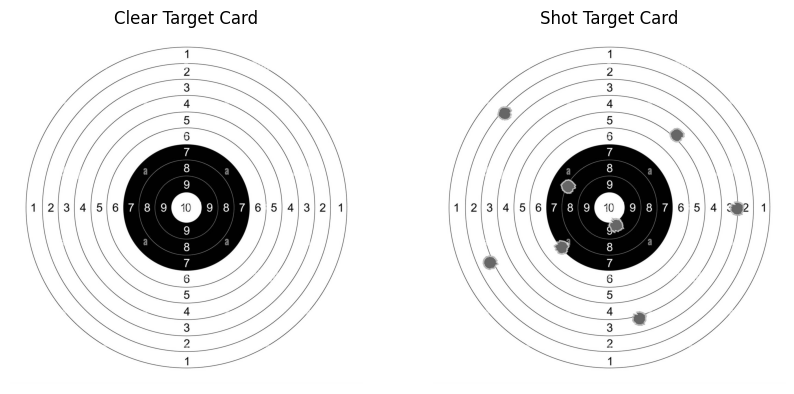

In [3]:
target_card = cv2.imread('lolap1_1.bmp')
target_card_shot = cv2.imread('lolap1_2.bmp')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(target_card, cv2.COLOR_BGR2RGB))
axs[0].set_title('Clear Target Card')
axs[1].imshow(cv2.cvtColor(target_card_shot, cv2.COLOR_BGR2RGB))
axs[1].set_title('Shot Target Card')
axs[0].axis('off'); axs[1].axis('off');

In [4]:
# Hough-transzformáció használatához szürkeárnyalator kép kell
target_card = cv2.cvtColor(target_card, cv2.COLOR_BGR2GRAY)
target_card_shot = cv2.cvtColor(target_card_shot, cv2.COLOR_BGR2GRAY)

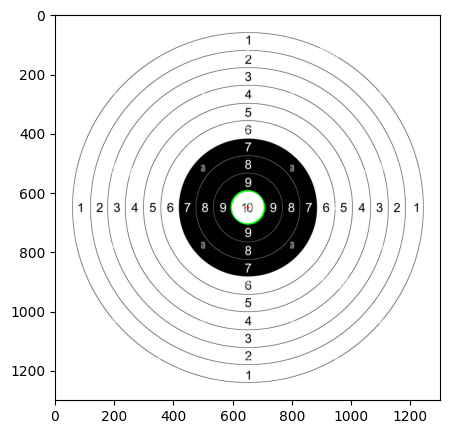

In [5]:
# Alapkörök megtalálása a lövések nélküli képen
circles = cv2.HoughCircles(target_card, cv2.HOUGH_GRADIENT, 1, 1, param1=200, param2=100, minRadius=10, maxRadius=100) # image, method, 1 (accumulator res = img res), minDist,

target_card = cv2.cvtColor(target_card, cv2.COLOR_GRAY2BGR)
circles = np.uint16(np.around(circles))
for i in circles[0, :]:
  cv2.circle(target_card, (i[0], i[1]), i[2], (0, 255, 0), 2)
  cv2.circle(target_card, (i[0], i[1]), 2, (0, 0, 255), 3)

# show target card
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(cv2.cvtColor(target_card, cv2.COLOR_BGR2RGB))